# TensorFlow2.0教程-使用RNN实现文本分类

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)


2.0.0-alpha0


## 1.使用tensorflow_datasets 构造输入数据

In [2]:
!pip install -q tensorflow_datasets

spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.3 which is incompatible.
plotnine 0.5.1 has requirement matplotlib>=3.0.0, but you'll have matplotlib 2.2.2 which is incompatible.
plotnine 0.5.1 has requirement pandas>=0.23.4, but you'll have pandas 0.23.0 which is incompatible.
neo4j-driver 1.6.2 has requirement neotime==1.0.0, but you'll have neotime 1.7.2 which is incompatible.
mizani 0.5.3 has requirement pandas>=0.23.4, but you'll have pandas 0.23.0 which is incompatible.
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1 which is incompatible.
You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                         as_supervised=True) 

获取训练集、测试集

In [4]:
train_dataset, test_dataset = dataset['train'], dataset['test']

获取tokenizer对象，用进行字符处理级id转换（这里先转换成subword，再转换为id）等操作

In [6]:
tokenizer = info.features['text'].encoder
print('vocabulary size: ', tokenizer.vocab_size)

vocabulary size:  8185


token对象测试

In [9]:
sample_string = 'Hello word , Tensorflow'
tokenized_string = tokenizer.encode(sample_string)
print('tokened id: ', tokenized_string)

# 解码会原字符串
src_string = tokenizer.decode(tokenized_string)
print('original string: ', src_string)

tokened id:  [4025, 222, 2621, 1199, 6307, 2327, 2934]
original string:  Hello word , Tensorflow


解出每个subword

In [12]:
for t in tokenized_string:
    print(str(t)+'->['+tokenizer.decode([t])+ ']')

4025->[Hell]
222->[o ]
2621->[word]
1199->[ , ]
6307->[Ten]
2327->[sor]
2934->[flow]


构建批次训练集

In [13]:
BUFFER_SIZE=10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)



## 模型构建
下面，因为此处的句子是变长的，所以只能使用序列模型，而不能使用keras的函数api

In [29]:
# def get_model():
#     inputs = tf.keras.Input((1240,))
#     emb = tf.keras.layers.Embedding(tokenizer.vocab_size, 64)(inputs)
#     h1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(emb)
#     h1 = tf.keras.layers.Dense(64, activation='relu')(h1)
#     outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h1)
#     model = tf.keras.Model(inputs, outputs)
#     return model

def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model
    

In [30]:
model = get_model()
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## 模型训练

In [31]:
history = model.fit(train_dataset, epochs=10,
                   validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 827s 2s/step - loss: 0.5606 - accuracy: 0.7068 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 798s 2s/step - loss: 0.4964 - accuracy: 0.7725 - val_loss: 0.5414 - val_accuracy: 0.7545
Epoch 3/10
391/391 [==============================] - 788s 2s/step - loss: 0.4347 - accuracy: 0.8076 - val_loss: 0.4571 - val_accuracy: 0.8075
Epoch 4/10
391/391 [==============================] - 795s 2s/step - loss: 0.4185 - accuracy: 0.8129 - val_loss: 0.4733 - val_accuracy: 0.8141
Epoch 5/10
391/391 [==============================] - 806s 2s/step - loss: 0.3016 - accuracy: 0.8824 - val_loss: 0.4644 - val_accuracy: 0.7839
Epoch 6/10
391/391 [==============================] - 793s 2s/step - loss: 0.2672 - accuracy: 0.8996 - val_loss: 0.5584 - val_accuracy: 0.7959
Epoch 7/10
391/391 [==============================] - 796s 2s/step - loss: 0.2302 - accuracy: 0.9144 - val_loss: 0.4058 - val_accuracy

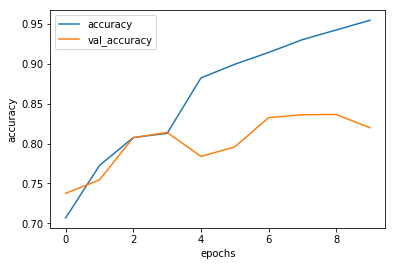

In [34]:
# 查看训练过程
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')

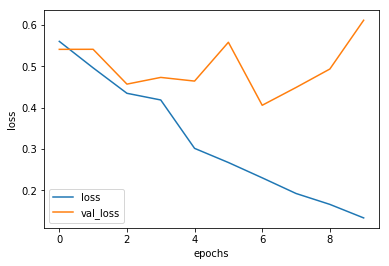

In [35]:
plot_graphs(history, 'loss')

测试

In [32]:
test_loss, test_acc = model.evaluate(test_dataset)
print('test loss: ', test_loss)
print('test acc: ', test_acc)

    391/Unknown - 68s 174ms/step - loss: 0.6117 - accuracy: 0.8199test loss:  0.6117385012262008
test acc:  0.81988


上述模型不会mask掉序列的padding，所以如果在有padding的寻列上训练，测试没有padding的序列时可能有所偏差。


In [44]:
def pad_to_size(vec, size):
    zeros = [0] * (size-len(vec))
    vec.extend(zeros)
    return vec

def sample_predict(sentence, pad=False):
    
    tokened_sent = tokenizer.encode(sentence)
    if pad:
        tokened_sent = pad_to_size(tokened_sent, 64)
    pred = model.predict(tf.expand_dims(tokened_sent, 0))
    return pred
    

In [47]:
# 没有padding的情况
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.2938048]]


In [48]:
# 有paddin的情况
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.42541984]]


## 堆叠更多的lstm层

In [52]:
from tensorflow.keras import layers
model = keras.Sequential(
[
    layers.Embedding(tokenizer.vocab_size, 64),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [54]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

In [56]:
history=model.fit(train_dataset, epochs=6, validation_data=test_dataset)

Epoch 1/6
391/391 [==============================] - 1646s 4s/step - loss: 0.5270 - accuracy: 0.7414 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
391/391 [==============================] - 1576s 4s/step - loss: 0.3900 - accuracy: 0.8320 - val_loss: 0.5222 - val_accuracy: 0.7726
Epoch 3/6
391/391 [==============================] - 1568s 4s/step - loss: 0.3559 - accuracy: 0.8538 - val_loss: 0.4429 - val_accuracy: 0.8162
Epoch 4/6
391/391 [==============================] - 1590s 4s/step - loss: 0.2504 - accuracy: 0.9059 - val_loss: 0.4470 - val_accuracy: 0.8091
Epoch 5/6
391/391 [==============================] - 1608s 4s/step - loss: 0.1977 - accuracy: 0.9280 - val_loss: 0.4762 - val_accuracy: 0.8222
Epoch 6/6
391/391 [==============================] - 1622s 4s/step - loss: 0.1619 - accuracy: 0.9430 - val_loss: 0.5484 - val_accuracy: 0.7808


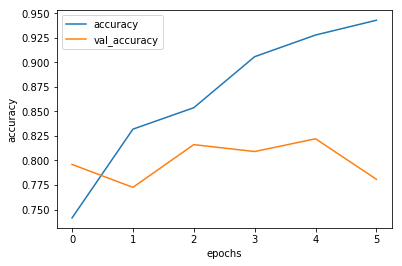

In [57]:
plot_graphs(history, 'accuracy')

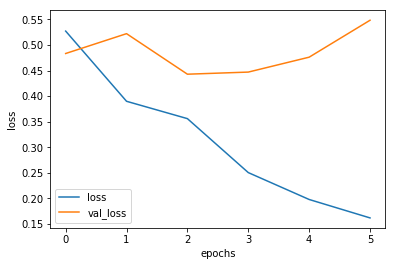

In [58]:
plot_graphs(history, 'loss')

In [59]:
res = model.evaluate(test_dataset)
print(res)

    391/Unknown - 125s 320ms/step - loss: 0.5484 - accuracy: 0.7808[0.5484032468570162, 0.78084]
